True 1 (7, 3)
True 1 (7, 3)
True 1 (7, 3)
True 1 (7, 3)
True 1 (7, 3)
True 1 (7, 3)
True 1 (7, 3)
True 1 (7, 3)
True 1 (7, 3)
True 1 (7, 3)
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.00241920e-15]
  [7.78046578e-15 1.33045965e-13 0.00000000e+00 1.15052506e-17]
  [0.00000000e+00 3.35882073e-12 0.00000000e+00 7.47429725e-14]
  [1.25809915e-15 4.65962648e-15 7.09126314e-13 7.74239191e-11]
  [1.53963335e-13 1.79264903e-10 1.97315047e-16 3.06456118e-09]
  [2.03041086e-09 2.13793579e-08 3.88763299e-13 4.14350498e-10]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.30222388e-13]
  [4.19950136e-15 1.07815060e-13 0.00000000e+00 3.73164716e-11]
  [1.45541420e-16 0.00000000e+00 0.00000000e+00 2.66049277e-10]
  [8.35075319e-13 1.25495720e-08 5.66818526e-12 3.86160086e-10]
  [3.19882958e-10 2.587075

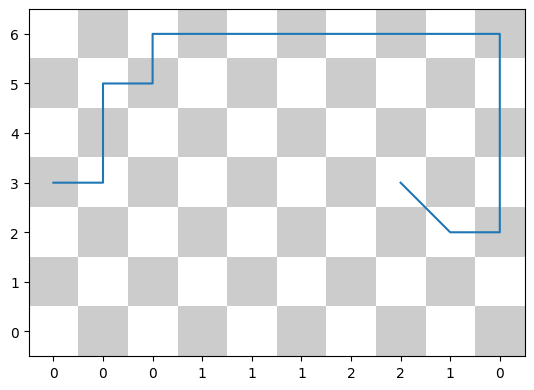

In [91]:
import numpy as np
import random
import matplotlib.pyplot as plt

class WindyGridWorld:
    def __init__(self) -> None:
        self.width = 10
        self.height = 7
        self.start = (0,3)
        self.end = (7,3)
        self.wins = (0,0,0,1,1,1,2,2,1,0)
        self.pos = list(self.start)

    def state_space(self):
        return (self.width, self.height)
    
    def action_space(self):
        return 4
    
    def reset(self):
        self.pos = list(self.start)
        return tuple(self.pos)

    def step(self, action):
        win = self.wins[self.pos[0]]
        match action:
            case 0:#left
                self.pos[0] = max(self.pos[0]-1, 0)
            case 1:#right
                self.pos[0] = min(self.pos[0]+1, self.width-1)
            case 2:#down
                self.pos[1] = max(self.pos[1]-1, 0)
            case 3:#up
                self.pos[1] = min(self.pos[1]+1, self.height-1)
        self.pos[1] = min(self.pos[1] + win, self.height-1)
        terminated = self.pos == list(self.end)
        reward = 1 if terminated else 0
        return terminated, reward, tuple(self.pos)
    

def epsilon_greed(qs, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(len(qs))
    else:
        return qs.argmax()
    

def sarsa(env, num_episodes, alpha, epsilon, gamma = 1.0):
    state_shape = env.state_space()
    action_shape = env.action_space()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    for episode in range(num_episodes):
        state = env.reset()
        action = epsilon_greed(qs[state], epsilon)
        while True:
            terminated, reward, next_state = env.step(action)
            if terminated:
                print(terminated, reward, next_state)
            if terminated:
                q_prime = 0
            else:
                next_action = epsilon_greed(qs[next_state], epsilon)
                q_prime = qs[next_state][next_action]
            qs[state][action] += (reward + q_prime * gamma - qs[state][action])*alpha
            state = next_state
            action = next_action
            if terminated:
                break
    #print(qs)
    return qs.argmax(-1)


def sarsa_n_step(n, env, num_episodes, alpha, epsilon, gamma = 1.0):
    state_shape = env.state_space()
    action_shape = env.action_space()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)

    states = np.zeros((n,len(state_shape)), dtype=int)
    actions = np.zeros(n, dtype=int)
    rewards = np.zeros(n, dtype=float)

    for episode in range(num_episodes):
        terminated = False
        t = 0
        state = env.reset()
        action = epsilon_greed(qs[state], epsilon)
        while True:
            if not terminated:
                terminated_t = t
                terminated, reward, next_state = env.step(action)
                states[t%n] = state
                actions[t%n] = action
                rewards[t%n] = reward
                state = next_state
                if not terminated:
                    next_action = epsilon_greed(qs[next_state], epsilon)
                    action = next_action
            elif t >= terminated_t + n:
                break

            if t + 1 >= n:
                tao = t + 1 - n
                last_reward_t = terminated_t if terminated else t
                q_prime = 0 if terminated else qs[next_state][next_action]
                g = reward + q_prime * gamma 
                for i in range(last_reward_t - 1, tao - 1, -1):
                    g = g * gamma + rewards[i%n]
                s_tao = tuple(states[tao%n])
                a_tao = actions[tao%n]
                qs[s_tao][a_tao] += (g - qs[s_tao][a_tao]) * alpha
            t += 1
    #print(qs)
    return qs.argmax(-1)
    
def test(env, policy):
    state = env.reset()
    action = policy[state]
    poses = [(state,action)]
    max_step = 100
    for n in range(max_step):
        terminated, reward, next_state = env.step(action)
        next_action = policy[next_state]
        state = next_state
        action = next_action
        poses.append((state,action))
        if terminated:
            break
    return poses

def draw(poses):
    width,height = env.state_space()
    board = np.ones((height, width, 3))
    board[1::2, ::2] = 0.8
    board[::2, 1::2] = 0.8
    plt.imshow(board,origin='lower')
    x = [pos[0][0] for pos in poses]
    y = [pos[0][1] for pos in poses]
    plt.plot(x, y)
    plt.xticks(range(width),labels=env.wins);
    plt.show()

env = WindyGridWorld()

#random.seed(0)
#np.random.seed(1)
policy1 = sarsa(env, 10, 0.1)
poses1 = test(env, policy1)
draw(poses1)

#random.seed(0)
#np.random.seed(1)
policy2 = sarsa_n_step(4, env, 10, 0.1)
poses2 = test(env, policy2)
#draw(poses2)
